# Temoral Difference
- Documentation: https://gymnasium.farama.org/environments/toy_text/blackjack/
- Your task is to fill all '# TODO' sections, so the Notebook can run from top to bottom
- Your allowed to edit any given code, but I recommend to use the existing structures
- Have a look to the existing outputs. Your outputs should have a simillar structure

### Prerequisites
- Install packages maplotlib

In [3]:
import os
import matplotlib
import copy
import time
import numpy
import datetime
import gymnasium
import numpy as np
from typing import Callable, NamedTuple
numpy.set_printoptions(precision=4)

### The environment

In [4]:
class StepInfo(NamedTuple):
    """Information about a single step in the environment"""
    State : tuple
    Action: int
    Reward : float
    Terminal : bool

class NormalizeStateWrapper(gymnasium.ObservationWrapper):
    """Modifies the state of the environment to be ready to use by our agents"""
    Buckets = 20

    def __init__(self, env):
        super().__init__(env)
        self.Offset = env.observation_space.low
        self.StepSize = (env.observation_space.high - env.observation_space.low)
        self.StepSize /= NormalizeStateWrapper.Buckets

    def observation(self, state):
        encoded = state - self.Offset
        encoded = (encoded / self.StepSize).astype(int)
        return tuple([i.item() for i in encoded])

def CreateEnvironment(render : bool = False) -> gymnasium.Env:
    """Creates the environment were an agent can interact with"""
    renderMode ="human" if render else None
    environment = gymnasium.make('MountainCar-v0', render_mode=renderMode)
    environment = NormalizeStateWrapper(environment)
    return environment

def PolicyRandom(env: gymnasium.Env) -> int:
    """Chooses the next action completly randomly"""
    print(env.action_space)
    return env.action_space.sample()

env = CreateEnvironment()
state, info = env.reset()
print("Start position")
print(state)

print('policy random:')
print(PolicyRandom(env))

Start position
(7, 10)
policy random:
Discrete(3)
2


### Logger

In [5]:
import json

class CheckPoint:
    def __init__(self):
        self.Sample: int = 0
        self.Data: dict[str, dict[str, float]] = {}

class Logger:
    """Information about a agent iterating in an environment"""

    def __init__(self, name:str = 'lorem', checkIntervall: int = 1):
        """Initializes and setups data based on the desired samples and checkups"""
        self.Name = name
        self.CheckIntervall = checkIntervall
        self.StartTime: float = time.time()
        self.CheckTime: float = time.time()
        self.CheckPoints: list[CheckPoint] = [CheckPoint()]
        self.Config: dict[str, any] = {}

    def MergeValue(oldVal: float | None, newVal: float, alpha: float) -> float:
        """Lets a value converge based on a alpha learnrate"""
        return newVal if oldVal is None else oldVal + (alpha * (newVal - oldVal))

    def FormatTime(time: float):
        return str(datetime.timedelta(seconds=int(time)))

    def FormatNumber(num: float, quantities: dict[str, float] = None):
        def fit(num: float, length: int = 6) -> str:
            label = format(num, f'.{length}f')
            cutoff = max(length, label.find('.'))
            return label[:cutoff]

        if (num is None): return '-'
        quantities = quantities or [(' ', 1), ('k', 1000), ('m', 1000**2), ('b', 1000**3), ('t', 1000**4)]
        for unit in reversed(quantities):
            value = float(num) / unit[1]
            if (value >= 1):
                return f'{fit(value)} {unit[0]}'

        return f'{fit(float(num) / quantities[0][1])} {quantities[0][0]}'


    def SetMetrics(self, metrics: dict[str, dict[str, float]], merge: float = 0.05):
        """Updates the current run performance only"""
        checkPoint = self.CheckPoints[-1]

        for group, newValues in metrics.items():
            currValues = checkPoint.Data.get(group)
            if currValues is not None:
                for name, newValue in newValues.items():
                    newValue = Logger.MergeValue(currValues.get(name), newValue, merge)
                    currValues[name] = newValue
            else:
                checkPoint.Data[group] = newValues

    def SetSample(self, sample: int, targetSamples: int, forcePrint: bool = False, onCheckpoint: Callable = None):
        """foobar"""
        checkPoint = self.CheckPoints[-1]
        checkPoint.Sample = sample
        isLastOne = sample == targetSamples - 1
        isCheckpoint = sample > 0 and (sample % self.CheckIntervall == 0)

        if (isLastOne or isCheckpoint or forcePrint):
            runTime = time.time() - self.StartTime
            stepTime = time.time() - self.CheckTime
            pendingTime = (runTime / sample) * (targetSamples - sample)
            progress = (sample*100) / targetSamples

            print(f'{Logger.FormatNumber(progress)} % >> 🕗 {Logger.FormatTime(pendingTime)} | {Logger.FormatTime(runTime)} | {Logger.FormatTime(stepTime)}', end='')
            for group, values in checkPoint.Data.items():
                stringValues = ' | '.join([f'{name} {Logger.FormatNumber(value)}' for name, value in values.items()])
                print(f'  >> {group} {stringValues}', end='')
            print()

            self.CheckTime = time.time()

        if isCheckpoint and onCheckpoint is not None:
            onCheckpoint()

        if not isLastOne and isCheckpoint:
            newCheck = copy.deepcopy(self.CheckPoints[-1])
            self.CheckPoints.append(newCheck)

    def Save(self, directory: str, name: str):
        os.makedirs(directory, exist_ok=True)
        path = os.path.join(directory, f'{name}.log')
        data = copy.deepcopy(self.__dict__)
        data['CheckPoints'] = [c.__dict__ for c in self.CheckPoints]
        with open(path, 'w') as file:
            json.dump(data, file, indent=4)

    def Load(path: str) -> 'Logger':
        with open(path, 'r') as file:
            data:dict = json.load(file)
        logger = Logger()
        logger.__dict__.update(data)
        logger.CheckPoints = []
        for c in data['CheckPoints']:
            cp = CheckPoint()
            cp.__dict__.update(c)
            logger.CheckPoints.append(cp)
        return logger

    def PrintBar(iteration, total, prefix = '', suffix = '', decimals = 2, length = 100, fill = '█', printEnd = "\r", finalEnd = "\n\r"):
        iteration += 1
        progress = iteration / float(total)
        percent = ("{0:." + str(decimals) + "f}").format(100 * progress)
        filledLength = int(length * progress)
        bar = fill * filledLength + '-' * (length - filledLength)
        print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
        if iteration == total:
            print(end=finalEnd)

### Agent

In [6]:
class Agent:
    """Manages all data and behaviour to interact within a environment"""

    ActionValueTable: numpy.ndarray
    """Holds the estimates or return for each possible state-action pair"""

    GymEnv: gymnasium.Env
    """Envornment where the agent is attached to"""

    def __init__(self, env: gymnasium.Env, tableShape: tuple):
        """Initializes the state value table and sets the environment"""
        self.ActionValueTable = numpy.zeros(tableShape)
        self.GymEnv = env

    def PolicyEpsilon(self, estimates: numpy.array, epsilon: float) -> int:
        """May chooses the next action either geedy or randomly based on the given epsilon probability"""
        if numpy.random.rand() < epsilon:
            actions = self.ActionValueTable.shape[-1]
            return numpy.random.randint(actions, size=1).item()
        else:
            argmax = numpy.where(estimates == estimates.max())
            return numpy.random.choice(argmax[0])

    def Estimate(self, state: tuple) -> numpy.array:
        return self.ActionValueTable[state]

    def Act(self, state: tuple, epsilon: float) -> int:
        """Chooses the next action based on the given state by estimating and applying the policy"""
        estimates = self.Estimate(state)
        nextAction = self.PolicyEpsilon(estimates, epsilon)
        return nextAction

In [7]:
# env = CreateEnvironment(False)
# TestAgent = Agent(env, (NormalizeStateWrapper.Buckets, NormalizeStateWrapper.Buckets, env.action_space.n))
# state, info = env.reset()
# action = TestAgent.Act(state,0.2)
# print(TestAgent.Estimate(state,action))


### Globals

In [8]:
gamma = 0.99
learnRate = 0.04
epsilon = 1.0/8.0
sampleCount = 3_000_000

### 1-Step SARSA

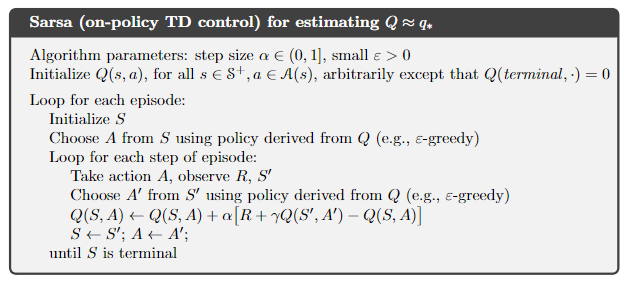

In [9]:
env = CreateEnvironment(False)
s1Agent = Agent(env, (NormalizeStateWrapper.Buckets, NormalizeStateWrapper.Buckets, env.action_space.n))
s1Info = Logger('1-Step SARSA', sampleCount / 100)

sample = 0
while(sample < sampleCount):
    state, info = env.reset()
    runReturn = 0
    runLength = 0
    hasEnded = False
    sequence: list[StepInfo] = []

    while not hasEnded or len(sequence) > 1:
        # Play
        if not hasEnded:
            action = s1Agent.Act(state, epsilon)
            nextState, reward, terminated, truncated, info = env.step(action)
            sequence.append(StepInfo(state, action, reward, False))

            hasEnded = terminated or truncated
            runReturn += reward
            runLength += 1
            state = nextState

            if hasEnded:
                sequence.append(StepInfo(state, None, None, True))
                s1Info.SetMetrics({'🎮': {'ret':runReturn, 'len':runLength}})

        # Learn
        if len(sequence) > 1 or sequence[-1].Terminal:
            # TODO: Implement the algorithm from above

            step0 = sequence[0]  # (s_t, a_t, r_t)
            step1 = sequence[1] 

            if step1.Terminal:
                target = step0.Reward  # No future value at terminal state
            else:
                next_q = s1Agent.ActionValueTable[step1.State][step1.Action]
                target = step0.Reward + gamma * next_q


            current_q = s1Agent.ActionValueTable[step0.State][step0.Action]
            change = target - current_q

            # Update Q-value
            s1Agent.ActionValueTable[step0.State][step0.Action] += learnRate * change

            s1Info.SetMetrics({'🍕': {'loss':abs(change)}})
            s1Info.SetSample(sample, sampleCount)

            sequence.pop(0)
            sample += 1

1.0000   % >> 🕗 0:02:25 | 0:00:01 | 0:00:01  >> 🍕 loss 1.0468    >> 🎮 ret -200.0   | len 200.00  
2.0000   % >> 🕗 0:02:25 | 0:00:02 | 0:00:01  >> 🍕 loss 1.3645    >> 🎮 ret -200.0   | len 200.00  
3.0000   % >> 🕗 0:02:25 | 0:00:04 | 0:00:01  >> 🍕 loss 1.1775    >> 🎮 ret -200.0   | len 200.00  
4.0000   % >> 🕗 0:02:24 | 0:00:06 | 0:00:01  >> 🍕 loss 1.1227    >> 🎮 ret -200.0   | len 200.00  
5.0000   % >> 🕗 0:02:22 | 0:00:07 | 0:00:01  >> 🍕 loss 1.0942    >> 🎮 ret -199.9   | len 199.98  
6.0000   % >> 🕗 0:02:20 | 0:00:08 | 0:00:01  >> 🍕 loss 1.0831    >> 🎮 ret -199.9   | len 199.99  
7.0000   % >> 🕗 0:02:18 | 0:00:10 | 0:00:01  >> 🍕 loss 1.3192    >> 🎮 ret -199.6   | len 199.64  
8.0000   % >> 🕗 0:02:17 | 0:00:11 | 0:00:01  >> 🍕 loss 0.9852    >> 🎮 ret -197.8   | len 197.83  
9.0000   % >> 🕗 0:02:15 | 0:00:13 | 0:00:01  >> 🍕 loss 1.5505    >> 🎮 ret -199.9   | len 199.91  
10.000   % >> 🕗 0:02:14 | 0:00:14 | 0:00:01  >> 🍕 loss 1.0309    >> 🎮 ret -199.7   | len 199.77  
11.000   % >> 🕗 0:02

### 8-Step SARSA

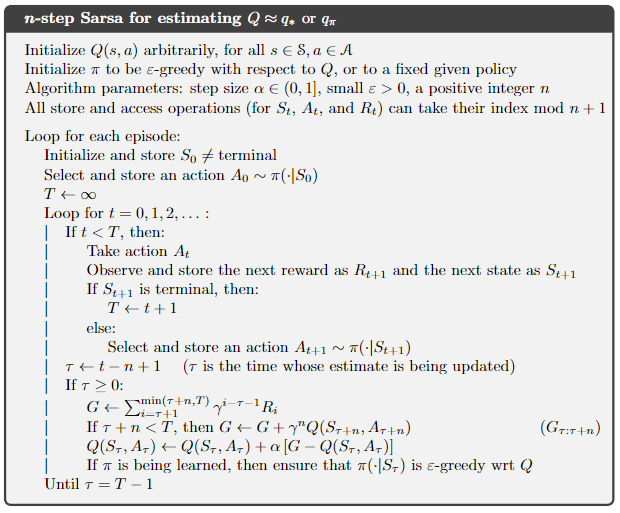

In [10]:
env = CreateEnvironment(False)
s8Agent = Agent(env, (NormalizeStateWrapper.Buckets, NormalizeStateWrapper.Buckets, env.action_space.n))
s8Info = Logger('8-Step SARSA', sampleCount / 100)

sample = 0
while(sample < sampleCount):
    state, info = env.reset()
    runReturn = 0
    runLength = 0
    hasEnded = False
    sequence: list[StepInfo] = []

    while not hasEnded or len(sequence) > 1:
        # Play
        if not hasEnded:
            action = s8Agent.Act(state, epsilon)
            nextState, reward, terminated, truncated, info = env.step(action)
            sequence.append(StepInfo(state, action, reward, False))

            hasEnded = terminated or truncated
            runReturn += reward
            runLength += 1
            state = nextState

            if hasEnded:
                sequence.append(StepInfo(state, None, None, True))
                s8Info.SetMetrics({'🎮': {'ret':runReturn, 'len':runLength}})

        # Learn
        if len(sequence) > 8 or sequence[-1].Terminal:
            # TODO: Implement the algorithm from above

            step0 = sequence[0]

            total_reward = 0
            max_steps_to_look_ahead = 8  # Because we're doing 8-step SARSA
            steps_we_can_actually_use = min(max_steps_to_look_ahead, len(sequence)-1)

            for step in range(steps_we_can_actually_use):
                # Get how many steps ahead we're looking (1 to 8)
                steps_ahead = step + 1
                
                # Get the reward at that future step
                future_reward = sequence[steps_ahead].Reward
                if future_reward is None:
                    future_reward = 0 
                
                # Calculate how much to discount this future reward
                discount = gamma ** step  # gamma^0 for step 1, gamma^1 for step 2, etc.
                
                # Add the discounted reward to our total
                total_reward += discount * future_reward

                # total_reward+= (sequence[steps_ahead].Reward) * (gamma**step)



            G = total_reward

            if len(sequence) > 8 and not sequence[-1].Terminal:
                step8 = sequence[8]
                G += (gamma ** 8) * s8Agent.ActionValueTable[step8.State][step8.Action]

            # Calculate change and update
            current_q = s8Agent.ActionValueTable[step0.State][step0.Action]
            change = G - current_q

            # Update Q-value
            s8Agent.ActionValueTable[step0.State][step0.Action] += learnRate * change


            s8Info.SetMetrics({'🍕': {'loss':abs(change)}})
            s8Info.SetSample(sample, sampleCount)

            sequence.pop(0)
            sample += 1

1.0000   % >> 🕗 0:02:36 | 0:00:01 | 0:00:01  >> 🍕 loss 5.7210    >> 🎮 ret -200.0   | len 200.00  
2.0000   % >> 🕗 0:02:35 | 0:00:03 | 0:00:01  >> 🍕 loss 8.2962    >> 🎮 ret -200.0   | len 200.00  
3.0000   % >> 🕗 0:02:33 | 0:00:04 | 0:00:01  >> 🍕 loss 4.4098    >> 🎮 ret -199.9   | len 199.92  
4.0000   % >> 🕗 0:02:32 | 0:00:06 | 0:00:01  >> 🍕 loss 3.6720    >> 🎮 ret -199.7   | len 199.71  
5.0000   % >> 🕗 0:02:30 | 0:00:07 | 0:00:01  >> 🍕 loss 2.5415    >> 🎮 ret -199.8   | len 199.89  
6.0000   % >> 🕗 0:02:29 | 0:00:09 | 0:00:01  >> 🍕 loss 7.5474    >> 🎮 ret -196.5   | len 196.54  
7.0000   % >> 🕗 0:02:28 | 0:00:11 | 0:00:01  >> 🍕 loss 4.5271    >> 🎮 ret -193.9   | len 193.99  
8.0000   % >> 🕗 0:02:27 | 0:00:12 | 0:00:01  >> 🍕 loss 3.4264    >> 🎮 ret -165.6   | len 165.60  
9.0000   % >> 🕗 0:02:26 | 0:00:14 | 0:00:01  >> 🍕 loss 1.9245    >> 🎮 ret -177.4   | len 177.43  
10.000   % >> 🕗 0:02:25 | 0:00:16 | 0:00:01  >> 🍕 loss 1.7834    >> 🎮 ret -195.0   | len 195.07  
11.000   % >> 🕗 0:02

### Importance Sampling

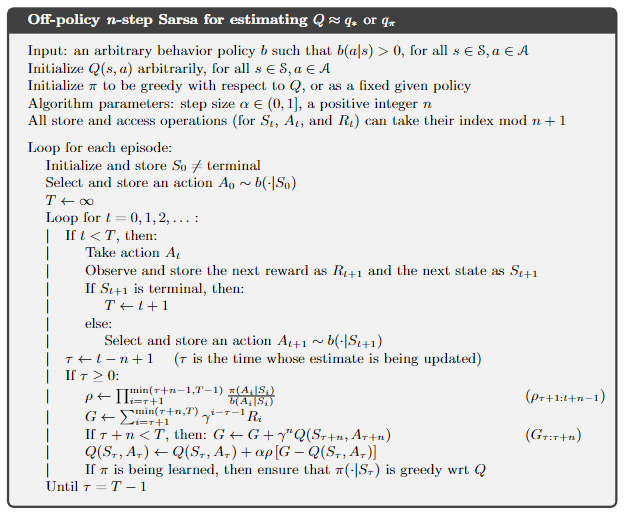

In [11]:
class StepInfoRatio(NamedTuple):
    State : numpy.ndarray
    Action: int
    Reward : float
    Terminal : bool
    Ratio: float

env = CreateEnvironment(False)
isAgent = Agent(env, (NormalizeStateWrapper.Buckets, NormalizeStateWrapper.Buckets, env.action_space.n))
isInfo = Logger('Importance Sampling', sampleCount / 100)

sample = 0
while(sample < sampleCount):
    state, info = env.reset()
    runReturn = 0
    runLength = 0
    hasEnded = False
    sequence: list[StepInfoRatio] = []

    while not hasEnded or len(sequence) > 1:
        # Play
        if not hasEnded:
            action = isAgent.Act(state, epsilon)
            nextState, reward, terminated, truncated, info = env.step(action)

            # TODO: Compute the importance sampling ratio
            q_values = isAgent.Estimate(state)
            greedy_action = np.argmax(q_values)

            # Deterministic greedy policy: 1.0 if you took the greedy action, else 0.0
            target_prob = 1.0 if action == greedy_action else 0.0


            #computing b/s
            num_actions = env.action_space.n

            if action == greedy_action:
                behavior_prob = 1 - epsilon + (epsilon / num_actions)
            else:
                behavior_prob = epsilon / num_actions

            ratio = target_prob / behavior_prob if behavior_prob > 0 else 0.0




            sequence.append(StepInfoRatio(state, action, reward, False, ratio))

            hasEnded = terminated or truncated
            runReturn += reward
            runLength += 1
            state = nextState

            if hasEnded:
                sequence.append(StepInfoRatio(state, None, None, True, 0))
                isInfo.SetMetrics({'🎮': {'ret':runReturn, 'len':runLength}})

        # Learn
        if len(sequence) > 8 or sequence[-1].Terminal:
            # TODO: Implement the algorithm from above
            step0 = sequence[0]  # (s_t, a_t, r_t, terminal, ratio)

            total_reward = 0
            max_steps_to_look_ahead = 8  # Because we're doing 8-step SARSA
            steps_we_can_actually_use = min(max_steps_to_look_ahead, len(sequence)-1)
            
            # Calculate product of importance ratios (ρ)
            rho_product = 1.0
            for step in range(steps_we_can_actually_use):
                steps_ahead = step + 1
                
                # Get the reward at that future step
                future_reward = sequence[steps_ahead].Reward
                if future_reward is None:
                    future_reward = 0
                
                # Calculate discount
                discount = gamma ** step  # gamma^0 for step 1, gamma^1 for step 2, etc.
                
                # Add the discounted reward to our total
                total_reward += discount * future_reward
                
                # Multiply importance ratios (skip for the last step)
                if steps_ahead < steps_we_can_actually_use:
                    rho_product *= sequence[steps_ahead].Ratio

            G = total_reward

            if len(sequence) > 8 and not sequence[-1].Terminal:
                step8 = sequence[8]
                G += (gamma ** 8) * isAgent.ActionValueTable[step8.State][step8.Action]

            # Calculate change with importance sampling
            current_q = isAgent.ActionValueTable[step0.State][step0.Action]
            change = rho_product * (G - current_q)

            # Update Q-value
            isAgent.ActionValueTable[step0.State][step0.Action] += learnRate * change

            isInfo.SetMetrics({'🍕': {'loss':abs(change)}})
            isInfo.SetSample(sample, sampleCount)

            sequence.pop(0)
            sample += 1

1.0000   % >> 🕗 0:03:03 | 0:00:01 | 0:00:01  >> 🍕 loss 5.7420    >> 🎮 ret -200.0   | len 200.00  
2.0000   % >> 🕗 0:03:04 | 0:00:03 | 0:00:01  >> 🍕 loss 2.1069    >> 🎮 ret -200.0   | len 200.00  
3.0000   % >> 🕗 0:03:02 | 0:00:05 | 0:00:01  >> 🍕 loss 4.5477    >> 🎮 ret -200.0   | len 200.00  
4.0000   % >> 🕗 0:02:59 | 0:00:07 | 0:00:01  >> 🍕 loss 2.6300    >> 🎮 ret -199.9   | len 199.96  
5.0000   % >> 🕗 0:02:57 | 0:00:09 | 0:00:01  >> 🍕 loss 3.4235    >> 🎮 ret -199.7   | len 199.78  
6.0000   % >> 🕗 0:02:55 | 0:00:11 | 0:00:01  >> 🍕 loss 3.4831    >> 🎮 ret -196.8   | len 196.85  
7.0000   % >> 🕗 0:02:53 | 0:00:13 | 0:00:01  >> 🍕 loss 2.2835    >> 🎮 ret -197.0   | len 197.06  
8.0000   % >> 🕗 0:02:52 | 0:00:14 | 0:00:01  >> 🍕 loss 3.8067    >> 🎮 ret -199.5   | len 199.57  
9.0000   % >> 🕗 0:02:49 | 0:00:16 | 0:00:01  >> 🍕 loss 4.1646    >> 🎮 ret -182.2   | len 182.26  
10.000   % >> 🕗 0:02:47 | 0:00:18 | 0:00:01  >> 🍕 loss 4.5575    >> 🎮 ret -181.2   | len 181.29  
11.000   % >> 🕗 0:02

### Q-Learning

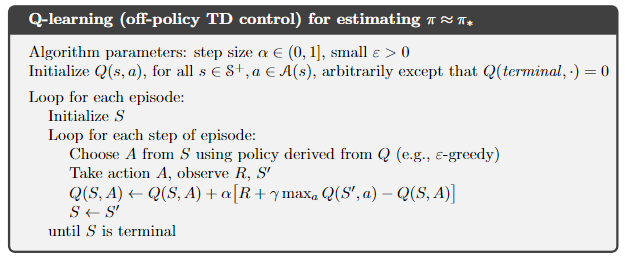

In [12]:
env = CreateEnvironment(False)
qlAgent = Agent(env, (NormalizeStateWrapper.Buckets, NormalizeStateWrapper.Buckets, env.action_space.n))
qlInfo = Logger('Q-Learning', sampleCount / 100)

sample = 0
while(sample < sampleCount):
    state, info = env.reset()
    runReturn = 0
    runLength = 0
    hasEnded = False
    sequence: list[StepInfo] = []

    while not hasEnded or len(sequence) > 1:
        # Play
        if not hasEnded:
            action = qlAgent.Act(state, epsilon)
            nextState, reward, terminated, truncated, info = env.step(action)
            sequence.append(StepInfo(state, action, reward, False))

            hasEnded = terminated or truncated
            runReturn += reward
            runLength += 1
            state = nextState

            if hasEnded:
                sequence.append(StepInfo(state, None, None, True))
                qlInfo.SetMetrics({'🎮': {'ret':runReturn, 'len':runLength}})

        # Learn
        if len(sequence) > 1 or sequence[-1].Terminal:
            # TODO: Implement the algorithm from above
            # Get current experience (S, A, R)
            step0 = sequence[0]  # (state, action, reward, terminal)
            step1 = sequence[1]
            #state, action, reward, _ = step0
            
            # Get next state (S') from sequence or terminal marker
            if step1.Terminal:
                # Terminal state has no future rewards
                max_next_q = 0.0
            else:
                next_state = step1.State
                # Q-learning uses max Q(S',a) - different from SARSA
                max_next_q = np.max(qlAgent.ActionValueTable[next_state])
            #print(max_next_q)
            # Q-learning update rule
            current_q = qlAgent.ActionValueTable[step0.State][step0.Action]
            target = reward + gamma * max_next_q
            change = target - current_q
            
            # Update Q-value
            qlAgent.ActionValueTable[step0.State][step0.Action] += learnRate * change

            qlInfo.SetMetrics({'🍕': {'loss':abs(change)}})
            qlInfo.SetSample(sample, sampleCount)

            sequence.pop(0)
            sample += 1

1.0000   % >> 🕗 0:02:45 | 0:00:01 | 0:00:01  >> 🍕 loss 1.0577    >> 🎮 ret -200.0   | len 200.00  
2.0000   % >> 🕗 0:02:41 | 0:00:03 | 0:00:01  >> 🍕 loss 1.1039    >> 🎮 ret -200.0   | len 200.00  
3.0000   % >> 🕗 0:02:38 | 0:00:04 | 0:00:01  >> 🍕 loss 1.1896    >> 🎮 ret -200.0   | len 200.00  
4.0000   % >> 🕗 0:02:36 | 0:00:06 | 0:00:01  >> 🍕 loss 1.3148    >> 🎮 ret -199.9   | len 199.96  
5.0000   % >> 🕗 0:02:34 | 0:00:08 | 0:00:01  >> 🍕 loss 1.0893    >> 🎮 ret -199.9   | len 199.99  
6.0000   % >> 🕗 0:02:32 | 0:00:09 | 0:00:01  >> 🍕 loss 1.1326    >> 🎮 ret -199.8   | len 199.83  
7.0000   % >> 🕗 0:02:30 | 0:00:11 | 0:00:01  >> 🍕 loss 1.0921    >> 🎮 ret -198.8   | len 198.84  
8.0000   % >> 🕗 0:02:28 | 0:00:12 | 0:00:01  >> 🍕 loss 1.4291    >> 🎮 ret -195.0   | len 195.05  
9.0000   % >> 🕗 0:02:26 | 0:00:14 | 0:00:01  >> 🍕 loss 1.3125    >> 🎮 ret -198.7   | len 198.73  
10.000   % >> 🕗 0:02:25 | 0:00:16 | 0:00:01  >> 🍕 loss 1.2073    >> 🎮 ret -198.4   | len 198.41  
11.000   % >> 🕗 0:02

### Analysis

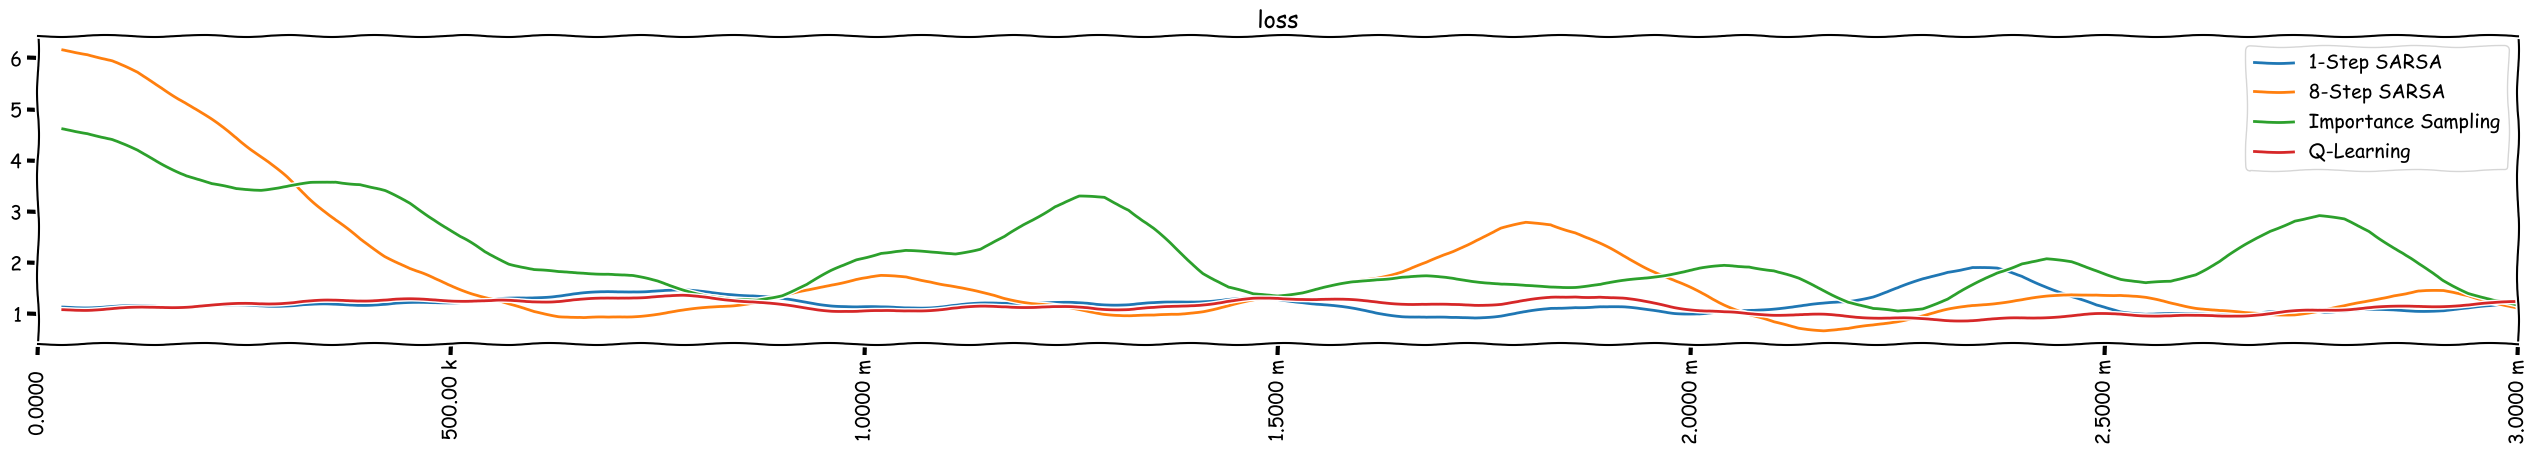

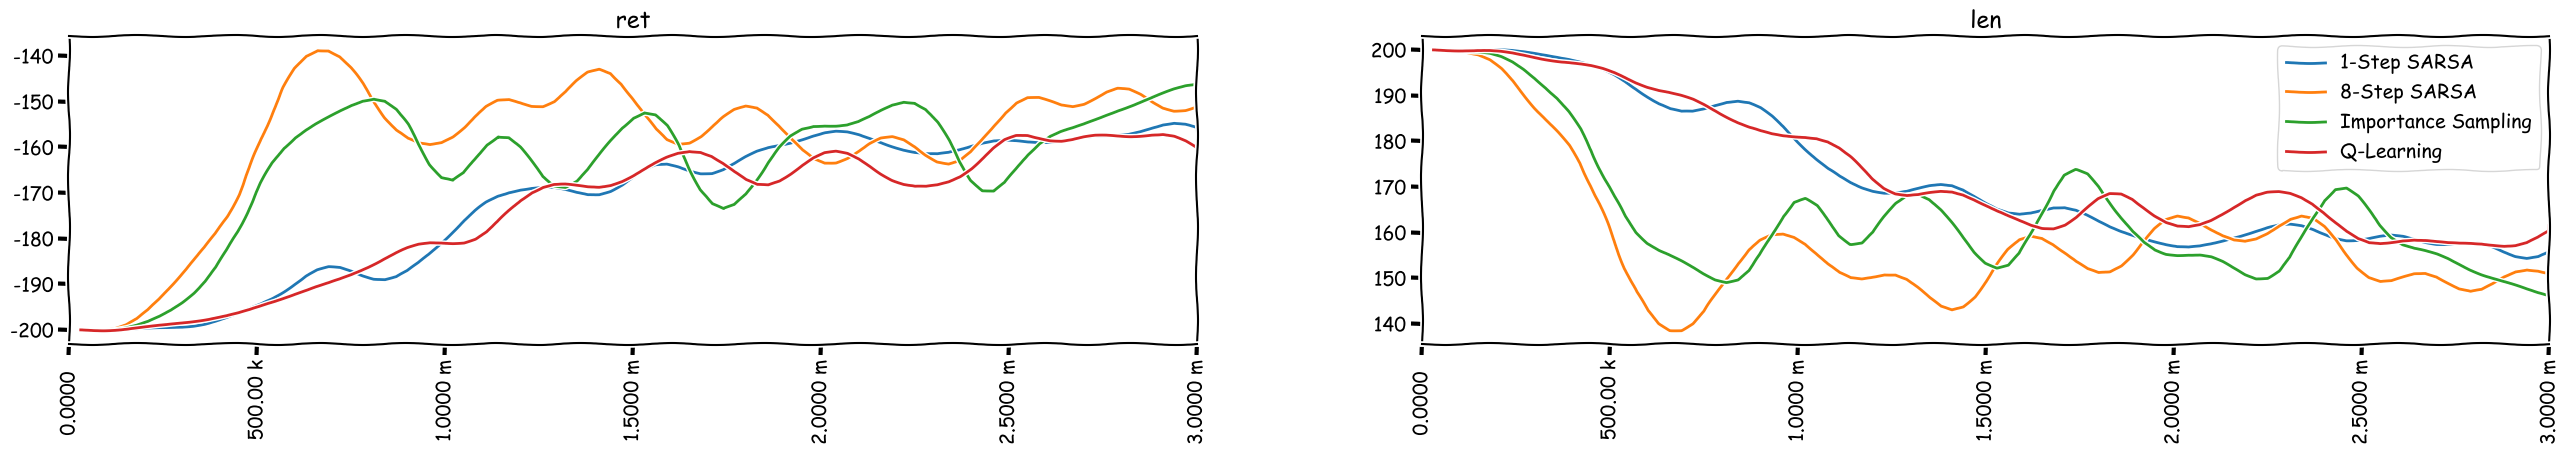

In [17]:
import matplotlib.pyplot as plt
import logging

def SmoothData(data, kSize = 4, recursion = 4):
    initialLength = len(data)
    data = numpy.pad(numpy.array(data), int(kSize / 2), 'edge')
    data = numpy.convolve(data, numpy.ones(kSize)/kSize, mode='valid')
    data = data[:initialLength]
    if recursion > 0: data = SmoothData(data, kSize, recursion - 1)
    return data

logs:list[Logger] = [s1Info, s8Info, isInfo, qlInfo]

struct:dict[str, set[str]] = {}
for l in logs:
    for c in l.CheckPoints:
        for g in c.Data.items():
            s = struct.get(g[0])
            if s is not None:
                struct[g[0]] = s.union(g[1].keys())
            else:
                struct[g[0]] = set(g[1].keys())

logging.getLogger('matplotlib.font_manager').disabled = True
with plt.xkcd():

    for group, metrics in struct.items():
        cols = len(metrics)
        fig, axes = plt.subplots(1, cols, figsize=(32, 4), squeeze=False)
        for i, metric in enumerate(metrics):
            xLimit = (0.0, 0.0)
            for log in logs:
                y = SmoothData([c.Data[group][metric] for c in log.CheckPoints])
                x = [c.Sample for c in log.CheckPoints]
                axes[0][i].plot(x, y, linestyle='-', label=log.Name)
                xLimit = (min(min(x), xLimit[0]), max(max(x), xLimit[1]))

            ticksX = axes[0][i].get_xticks()
            ticksL = [Logger.FormatNumber(x) for x in ticksX]
            axes[0][i].set_xticks(ticksX)
            axes[0][i].set_xticklabels(ticksL, rotation=90)
            axes[0][i].set_title(metric)
            axes[0][i].grid(True)
            axes[0][i].set_xlim(xLimit)
        plt.legend()
        plt.show()

### Watch the result

In [16]:
env = CreateEnvironment(False)
perfSamples = 1_000
results = []

for agent in [(s1Agent, '1-Step SARSA'), (s8Agent, '8-Step SARSA'), (isAgent, 'Importance Sampling'), (qlAgent, 'Q-Learning')]:
    allReturns = 0
    print(f'{agent[1]}:')
    for i in range(perfSamples):
        if i % (perfSamples / 50) == 0:
            print('.', end='')
        state, info = env.reset()
        while(True):
            action = agent[0].Act(state, 0)
            state, reward, terminated, truncated, info = env.step(action)
            allReturns += reward
            if terminated or truncated:
                break
    print(' Done')
    allReturns /= perfSamples
    results.append((allReturns, agent[1]))

print('\n\nRanking:')
results.sort(key=lambda e: -e[0])
for i, result in enumerate(results):
    print(f'\t{i+1}: {result[0]:0.2f} | {result[1]}')

1-Step SARSA:
.................................................. Done
8-Step SARSA:
.................................................. Done
Importance Sampling:
.................................................. Done
Q-Learning:
.................................................. Done


Ranking:
	1: -138.19 | Importance Sampling
	2: -143.04 | 8-Step SARSA
	3: -147.44 | Q-Learning
	4: -170.78 | 1-Step SARSA


In [12]:
env = CreateEnvironment(True)
for _ in range(5):
    state, info = env.reset()
    returns = 0
    print('Run: >> ', end='')
    for _ in range(200):
        action = isAgent.Act(state, 0)
        state, reward, terminated, truncated, info = env.step(action)
        returns += reward
        print('.', end='')
        if terminated:
            break
    print(f' >> {returns}')
env.close()

Run: >> ........................................................................................................................................ >> -136.0
Run: >> ...................................................................................................................................... >> -134.0
Run: >> ...................................................................................................................................... >> -134.0
Run: >> ...................................................................................................................................... >> -134.0
Run: >> ......................................................................................................................................... >> -137.0
